In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import datetime
from datetime import timedelta
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from platform import python_version

# Definitions of certain constants
DAY = datetime.timedelta(days=1)

RAIN_DESC = "rain perturbing etcp"
SIMUL_DESC = "Software simulation"
IRR_DESC = "Irrigation perturbing etcp"
NULL_PROFILE_DESC = "Null profile value"
DATA_BLIP_DESC = "Data blip"
LARGE_PROFILE_DIP_DESC = "Large profile dip"
ETCP_POS_DESC = "etcp is positive"
ETCP_OUTLIERS_DESC = "etcp outliers"
LUX_DESC = "Luxurious water uptake"
UNREDEEMABLE = [RAIN_DESC, SIMUL_DESC, IRR_DESC, NULL_PROFILE_DESC, DATA_BLIP_DESC,
                LARGE_PROFILE_DIP_DESC, ETCP_POS_DESC, ETCP_OUTLIERS_DESC, LUX_DESC]

# The following  are "redeemable"
HU_STUCK_DESC = "Heat Units `stuck`"
ET0_STUCK_DESC = "et0 `stuck`"
ETC_STUCK_DESC = "Stuck etc due to stuck eto"
REDEEMABLE = [HU_STUCK_DESC, ET0_STUCK_DESC, ETC_STUCK_DESC]

ET0_MAX = 12
KCP_MAX = 0.8
ETCP_MAX = ET0_MAX * KCP_MAX

In [3]:
print("Henri is using Python version 3.6.8.  You are using Python version {}.".format(python_version()))
print("Henri is using numpy version 1.15.4.  You are using numpy version {}.".format(np.__version__))
print("Henri is using pandas version 0.24.0.  You are using pandas version {}.".format(pd.__version__))
print("Henri is using matplotlib version 2.2.3.  You are using matplotlib version {}.".format(matplotlib.__version__))

Henri is using Python version 3.6.8.  You are using Python version 3.6.8.
Henri is using numpy version 1.15.4.  You are using numpy version 1.15.4.
Henri is using pandas version 0.24.0.  You are using pandas version 0.24.0.
Henri is using matplotlib version 2.2.3.  You are using matplotlib version 2.2.3.


# Define a helper function called `"flagger"`

This `"flagger"` function will set the flag value equal to 1 for faulty data.  The dates for which the flag value is equal to 1 will not be used in the new calculation of $k_{cp} = \frac{\mathrm{ET}_{cp}}{\mathrm{ET}_0}$.

`"flagger"` will also add a description in the `"description"` column about why a particular date has been flagged.

The `"flagger"` function only operates on the `"df_flag"` DataFrame (instantiated later in this notebook) which only has two columns:
1. `"binary_value"`
2. `"description"`  
`"df_flag"` also has a DateTime Index.

Later on, if desired, we can then merge the `"df_flag"` DataFrame with the main DataFrame containing all our data.  Our merging will take place in such a fashion that we merge entries corresponding to identical dates. (In short, we merge on the Index of our DataFrame).

In [4]:
def flagger(bad_dates, brief_desc, bin_value=0):
    """
    Flag bad_dates with a binary value of 1 and append a brief description about why bad_dates were flagged.
    
    Parameters:
    bad_dates (pandas.core.indexes.datetimes.DatetimeIndex):  Dates for which we cannot calculate k_cp because our readings were perturbed and rendered unuseful.
    brief_desc (str):  A very short description about why bad_dates were flagged.
    
    Returns:
    None.  It updates the DataFrame storing all the information related to flagging.  In this case the DataFrame is called `df_flag`    
    """
    if df_flag.loc[bad_dates, "description"].str.contains(brief_desc).all(axis=0):
        # The bad_dates have already been flagged for the reason given in brief_desc.
        # No use in duplicating brief_desc contents in the description column.
        # Therefore redundant information in the df_flag DataFrame is avoided.
        print("You have already flagged these dates for the reason given in `brief_desc`; No flagging has taken place.")
        return
    else:
        for d in bad_dates:
            cond = (brief_desc in df_flag.loc[d, "description"])
            if (df_flag.loc[d, "binary_value"] == 0) & (bin_value == 0) & (cond is True):
                continue
            elif (df_flag.loc[d, "binary_value"] == 0) & (bin_value == 0) & (cond is False):
                df_flag.loc[d, "description"] += (" " + brief_desc + ".")
            elif (df_flag.loc[d, "binary_value"] == 0) & (bin_value == 1) & (cond is True):
                df_flag.loc[d, "binary_value"] = 1
            elif (df_flag.loc[d, "binary_value"] == 0) & (bin_value == 1) & (cond is False):
                df_flag.loc[d, "binary_value"] = 1
                df_flag.loc[d, "description"] += (" " + brief_desc + ".")
            elif (df_flag.loc[d, "binary_value"] == 1) & (bin_value == 0) & (cond is True):
                continue
            elif (df_flag.loc[d, "binary_value"] == 1) & (bin_value == 0) & (cond is False):
                df_flag.loc[d, "description"] += (" " + brief_desc + ".")
            elif (df_flag.loc[d, "binary_value"] == 1) & (bin_value == 1) & (cond is True):
                continue
            else:  # (df_flag.loc[d, "binary_value"] == 1) & (bin_value == 1) & (cond is False)
                df_flag.loc[d, "description"] += (" " + brief_desc + ".")
        df_flag.loc[bad_dates, "description"] = df_flag.loc[:, "description"].apply(lambda s: s.lstrip().rstrip())

# Define a helper function named `"reporter"`:

This function prints statements regarding:
1. How much data was lost due to a specific flagging operation.
2. (Optional, `Default=False`) How much data remains useful after all the flagging that has taken place in the entire notebook session.

In [5]:
def reporter(brief_desc, remaining=False):
    tally = df_flag["description"].str.contains(brief_desc).sum()
    n_tot_entries = len(df_flag.index)
    perc = tally / n_tot_entries * 100
    print("{:.1f}% of data is affected due to [{}].".format(perc, brief_desc))
    
    if remaining:
        calc = 100 - df_flag["binary_value"].sum()/len(df_flag.index)*100
        print("After all the flagging that has taken place in this entire notebook, only {:.0f}% of your data is useful.".format(calc))

# The _Kouebokkeveld_ longterm data, and imputer definition:

In the following, we:
1. Define a DataFrame storing the _Kouebokkeveld_ long-term data.
2. Define the `kbv_imputer` function that tries to impute the long-term data into stuck/repeating eto values.

In [6]:
calendar_week = np.array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
                          35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
                          45, 46, 47, 48, 49,  1,  2,  3,  4,  5,
                           6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
                          16, 17, 18, 19, 20, 21, 22, 23, 24])

kbv_eto = np.array([2.3, 2.3, 2.3, 2.3, 2.3, 2.4, 2.5, 2.65, 2.8, 3.1,
                    3.4, 3.65, 4.0, 4.4, 4.8, 5.3, 5.8, 6.3, 6.7, 7.1,
                    7.6, 8.0, 8.3, 8.6, 8.8, 8.9, 8.9, 8.9, 8.8, 8.7,
                    8.5, 8.3, 8.0, 7.5, 7.0, 6.5, 5.8, 5.2, 4.7, 4.3,
                    3.7, 3.4, 3.1, 2.8, 2.5, 2.45, 2.4, 2.35, 2.3])

df_kbv = pd.DataFrame(data=kbv_eto[:], index=calendar_week[:], columns=["kbv_eto"])

In [7]:
def kbv_imputer(flagged_dates, dataframe, column_to_be_imputed, flag_dataframe):
    for d in flagged_dates:
        week_number = d.isocalendar()[1]
        try:
            dataframe.loc[d, [column_to_be_imputed]] = df_kbv.loc[week_number, "kbv_eto"]
            for description in UNREDEEMABLE:
                if description in flag_dataframe.loc[d, "description"]:
                    break
            else:
                flag_dataframe.loc[d, "binary_value"] = 0  # we have salvaged an entry.
                flag_dataframe.loc[d, "description"] = df_flag.loc[d, "description"].replace(ET0_STUCK_DESC, "Imputed eto")
        except KeyError:
            dataframe.loc[d, column_to_be_imputed] = np.nan
    return dataframe, flag_dataframe

# Specify the Probe-ID you are interested in:

Valid options are:
* `"P-370"`
* `"P-371"`
* `"P-372"`
* `"P-384"`
* `"P-391"`
* `"P-392"`
* `"P-891"`

You can change the Probe-ID in the following code-cell, and please remember to specify it in string format:

In [8]:
probe_id = "P-371"
assert isinstance(probe_id, str), "variable probe_id must be of type string!"

# Extract the data from our Excel file and store it in a `pandas DataFrame`.

- Notice in the following code cell, we extract the daily data for the probe of interest.

- In the for-loop, we remove the unnecessary leading white-space at the beginning of each column name.  After the redundant white-space has been removed, we assign the redundant-free column names to the dataframe.

In [9]:
data = pd.read_excel("Golden_Delicious_daily_data.xlsx", sheet_name=probe_id, index_col=0, parse_dates=True)
new_columns = []
for c in data.columns:
    new_columns.append(c.lstrip())
data.columns = new_columns
print(data.columns)

Index(['heat_units', 'rain', 'erain', 'total_irrig', 'tot_eff_irrig', 'etc',
       'ety', 'et0', 'etcp', 'rzone', 'available', 'days_left',
       'deficit_current', 'rzm', 'rzm_source', 'fcap', 'profile',
       'deficit_want', 'refill', 'et0_forecast_yr', 'original_unit_system'],
      dtype='object')


In the following code we create a standalone dataframe which will store flag values as well as descriptions on why a particular date was flagged as being inappropriate for our new calculation of $k_{cp}$.  At first, we initialise all our dates to a flag value of 0.  If during our analysis we realise that there are dates with junk data, we will update the flag value to be 1, and also provide a brief description.

In [10]:
df_flag = pd.DataFrame(index=data.index, columns=["binary_value", "description"])
df_flag["binary_value"] = 0
df_flag["description"] = str()  # we initialise this column with an empty string `""`
df_flag.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 2 columns):
binary_value    550 non-null int64
description     550 non-null object
dtypes: int64(1), object(1)
memory usage: 12.9+ KB


The following data columns are not of interest to us for our analysis:
* `rzone`
* `available`
* `days_left`
* `deficit_current`
* `rzm`
* `fcap`
* `deficit_want`
* `refill`
* `et0_forecast_yr`

Therefore, we are going to drop these columns from the `data` DataFrame:

In [11]:
data.drop(labels=["rzone", "available", "days_left", "deficit_current", "rzm", 
                  "fcap", "deficit_want", "refill", "et0_forecast_yr"], axis=1, inplace=True)

In [12]:
data["calendar_week"] = data.index.to_series().apply(lambda d: d.isocalendar()[1])

In [13]:
data.head()

,heat_units,rain,erain,total_irrig,tot_eff_irrig,etc,ety,et0,etcp,rzm_source,profile,original_unit_system,calendar_week
date,,,,,,,,,,,,,
2017-08-01,0.0,0.0,0.0,0.0,0.0,0.82,0.68,6.8,120.37,Electronic Probe,120.37,si,31
2017-08-02,0.0,1.0,0.0,0.0,0.0,0.49,0.68,6.8,1.32,Electronic Probe,121.69,si,31
2017-08-03,0.0,0.2,0.0,0.0,0.0,0.49,0.68,6.8,0.50,Electronic Probe,122.19,si,31
2017-08-04,0.0,0.0,0.0,0.0,0.0,0.49,0.68,6.8,0.71,Electronic Probe,122.91,si,31
2017-08-05,0.0,0.0,0.0,0.0,0.0,0.49,0.68,6.8,0.10,Electronic Probe,123.01,si,31


# `["etc", "et0"]` versus time

Notice that `"etc"` is column G in the Excel spreadsheet.  
`"et0"` is column I in the Excel spreadsheet.  
`"etcp"` lives in column J of the Excel spreadsheet.

In [14]:
df_et = data.filter(["calendar_week", "etc", "et0", "etcp"], axis=1)
df_et.head()

,calendar_week,etc,et0,etcp
date,,,,
2017-08-01,31,0.82,6.8,120.37
2017-08-02,31,0.49,6.8,1.32
2017-08-03,31,0.49,6.8,0.50
2017-08-04,31,0.49,6.8,0.71
2017-08-05,31,0.49,6.8,0.10


In [15]:
df_et["et0_diff1"] = df_et["et0"].diff(periods=1)
df_et["et0_diff2"] = df_et["et0"].diff(periods=2)
condition = (df_et["et0_diff1"] == 0.0) | (df_et["et0_diff2"] == 0)  # bitwise OR operation
bad_et0_days = df_et[condition].index

df_et["remaining_et0"] = df_et["et0"]
df_et.loc[bad_et0_days, ["remaining_et0"]] = np.nan

flagger(bad_dates=bad_et0_days, brief_desc=ET0_STUCK_DESC, bin_value=1)
reporter(brief_desc=ET0_STUCK_DESC)

53.8% of data is affected due to [et0 `stuck`].


In [16]:
print(df_flag)

            binary_value   description
date                                  
2017-08-01             0              
2017-08-02             1  et0 `stuck`.
2017-08-03             1  et0 `stuck`.
2017-08-04             1  et0 `stuck`.
2017-08-05             1  et0 `stuck`.
2017-08-06             1  et0 `stuck`.
2017-08-07             1  et0 `stuck`.
2017-08-08             1  et0 `stuck`.
2017-08-09             1  et0 `stuck`.
2017-08-10             1  et0 `stuck`.
2017-08-11             1  et0 `stuck`.
2017-08-12             1  et0 `stuck`.
2017-08-13             1  et0 `stuck`.
2017-08-14             1  et0 `stuck`.
2017-08-15             1  et0 `stuck`.
2017-08-16             1  et0 `stuck`.
2017-08-17             1  et0 `stuck`.
2017-08-18             0              
2017-08-19             0              
2017-08-20             0              
2017-08-21             0              
2017-08-22             0              
2017-08-23             0              
2017-08-24             0 

### Impute Kouebokkeveld data into stuck `eto` values.

In [17]:
df_et, df_flag = kbv_imputer(flagged_dates=bad_et0_days, dataframe=df_et,
                    column_to_be_imputed="remaining_et0", flag_dataframe=df_flag)

In [18]:
for d in df_flag.index:
    print("{} <---> {}".format(df_flag.loc[d, "binary_value"], df_flag.loc[d, "description"]))

0 <---> 
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> Imputed eto.
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> Imputed eto.
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <---> 
0 <-

### Flag `etc` values that are stuck

In [19]:
df_et["remaining_etc"] = df_et["etc"]
df_et.loc[bad_et0_days, ["remaining_etc"]] = np.nan

flagger(bad_dates=bad_et0_days, brief_desc=ETC_STUCK_DESC, bin_value=0)
reporter(brief_desc=ETC_STUCK_DESC)

53.8% of data is affected due to [Stuck etc due to stuck eto].


In [20]:
print(df_flag)

            binary_value                               description
date                                                              
2017-08-01             0                                          
2017-08-02             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-03             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-04             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-05             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-06             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-07             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-08             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-09             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-10             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-11             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-12             0  Imputed eto. Stuck etc due to stuck eto.
2017-08-13             0  Imputed eto. Stuck etc due to stuck 

<IPython.core.display.Javascript object>


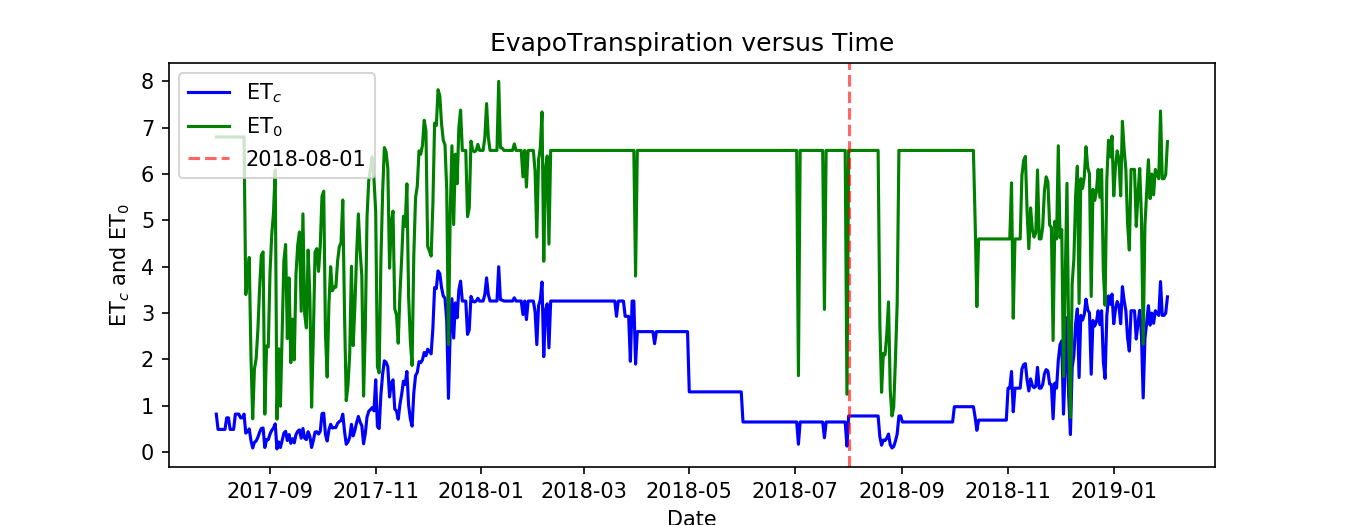

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 3.5)

ax.plot(df_et.index, df_et["etc"], color="blue", label="$\mathrm{ET}_c$")
ax.plot(df_et.index, df_et["et0"], color="green", label="$\mathrm{ET}_0$")
ax.axvline(x=datetime.datetime(2018, 8, 1), linestyle="--", color="red", alpha=0.6, label="2018-08-01")
ax.set_ylabel("$\mathrm{ET}_c$ and $\mathrm{ET}_0$")
ax.set_xlabel("Date")
ax.set_title("EvapoTranspiration versus Time")
ax.legend(loc=0)
plt.show()

There are time intervals for which `"et0"` (and also `"heat_units"`) are stuck: they repeat identical values for a long duration of time.  Obviously, it is not possible to get such repetitive values when considering the fact that weather data is very random.  The data entries associated with these repeating values are flagged.

It is rather unfortunate that a relatively large volume of data is lost when flagging these "stuck" values.

<IPython.core.display.Javascript object>


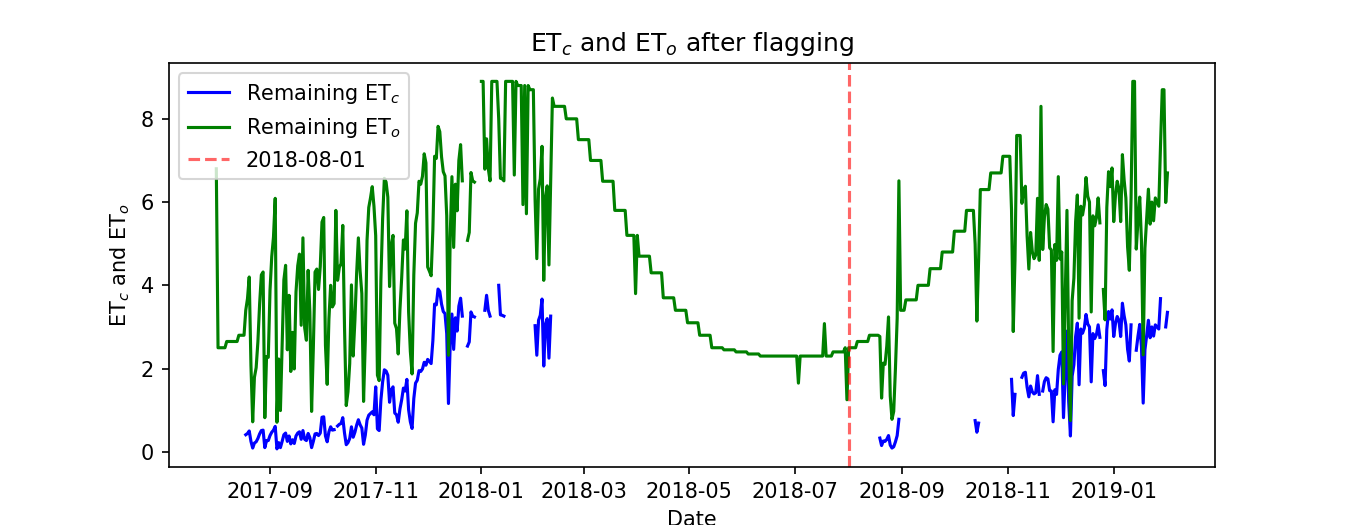

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 3.5)

ax.plot(df_et.index, df_et["remaining_etc"], color="blue", label="Remaining $\mathrm{ET}_c$")
ax.plot(df_et.index, df_et["remaining_et0"], color="green", label="Remaining $\mathrm{ET}_o$")
ax.axvline(x=datetime.datetime(2018, 8, 1), linestyle="--", color="red", alpha=0.6, label="2018-08-01")
ax.set_ylabel("$\mathrm{ET}_c$ and $\mathrm{ET}_o$")
ax.set_xlabel("Date")
ax.set_title("$\mathrm{ET}_c$ and $\mathrm{ET}_o$ after flagging")
ax.legend(loc=0)
plt.show()

In [23]:
et0_max = max(df_et["et0"])
print("The maximum (valid) et0 is equal to: {:.1f}.".format(et0_max))

The maximum (valid) et0 is equal to: 8.0.


# `"rain"` versus time

In the code cell below, we flag rain events in which:
* `"rain"` > 2 mm.

In [24]:
df_rain = data.filter(["rain"], axis=1)
df_rain.head()

condition = (df_rain["rain"] > 2)
flagged_rain_dates = df_rain[condition].index

flagger(bad_dates=flagged_rain_dates, brief_desc=RAIN_DESC, bin_value=1)
reporter(brief_desc=RAIN_DESC)

14.9% of data is affected due to [rain perturbing etcp].


In [25]:
print(df_flag)

            binary_value                                        description
date                                                                       
2017-08-01             0                                                   
2017-08-02             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-03             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-04             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-05             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-06             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-07             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-08             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-09             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-10             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-11             1  Imputed eto. Stuck etc due to stuck eto. rain ...
2017-08-12  

<IPython.core.display.Javascript object>


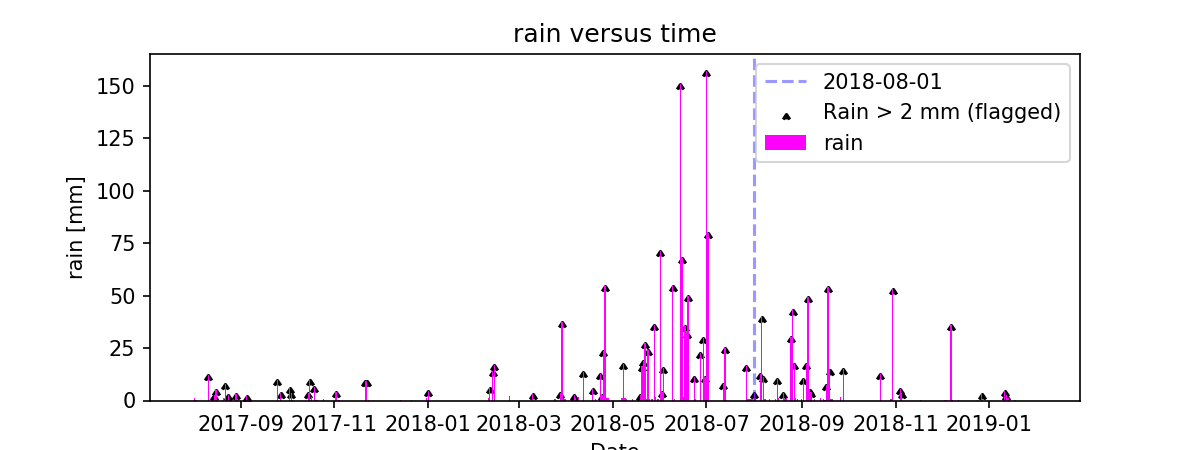

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.bar(x=df_rain.index, height=df_rain["rain"], color="magenta", label="rain")
ax.set_xlabel("Date")
ax.set_ylabel("rain [mm]")
ax.set_title("rain versus time")
ax.scatter(flagged_rain_dates, df_rain.loc[flagged_rain_dates, ["rain"]], label="Rain > 2 mm (flagged)", 
           c="black", marker=6, s=10, alpha=1)
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", ls="--", alpha=0.4, label="2018-08-01")
ax.legend()
plt.show()

The great majority of rain events are flagged.

There appears to be few rain events in which: rain < 2 mm.

# `"Total Irrigation"`

We need to flag data entries corresponding to irrigation events because it distorts our `"profile"` and `"etcp"` waterbalance readings.  This is somewhat complicated by the possibility of a **farmer logging an irrigation event on the wrong date.**

In [27]:
df_irr = data.filter(["total_irrig"], axis=1)
df_irr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
total_irrig    550 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB


Flag an irrigation data entry:
1. If the farmer logged irrigation taking place for that day, **AND**
2. If the cerresponding $\mathrm{ET}_{cp} > 0.5\cdot\mathrm{ET}_c$, **AND**
3. If there is no rain for that particular day: rain == 0.

Let us implement this in the following code cell:

In [28]:
conditions = (data["total_irrig"] > 0) & (data["etcp"] > 0.5*df_et["remaining_etc"]) & (data["rain"] == 0)
flag_irrigation_dates = data[conditions].index

flagger(bad_dates=flag_irrigation_dates, brief_desc=IRR_DESC, bin_value=1)
reporter(brief_desc=IRR_DESC)

4.7% of data is affected due to [Irrigation perturbing etcp].


In [29]:
print(df_flag)

            binary_value                                        description
date                                                                       
2017-08-01             0                                                   
2017-08-02             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-03             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-04             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-05             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-06             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-07             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-08             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-09             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-10             0           Imputed eto. Stuck etc due to stuck eto.
2017-08-11             1  Imputed eto. Stuck etc due to stuck eto. rain ...
2017-08-12  

<IPython.core.display.Javascript object>


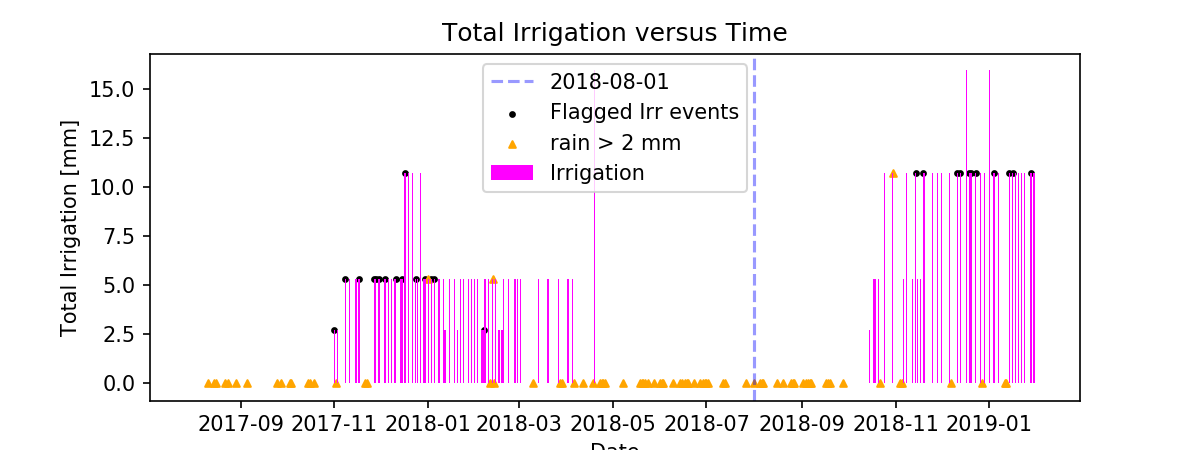

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.bar(df_irr.index, df_irr["total_irrig"], color="magenta", label="Irrigation")
ax.scatter(flag_irrigation_dates, df_irr.loc[flag_irrigation_dates, ["total_irrig"]], label="Flagged Irr events", 
           c="black", marker="o", s=5, alpha=1)
ax.scatter(flagged_rain_dates, df_irr.loc[flagged_rain_dates, ["total_irrig"]], label="rain > 2 mm",
           c="orange", marker="^", s=10, alpha=1)
ax.set_xlabel("Date")
ax.set_ylabel("Total Irrigation [mm]")
ax.set_title("Total Irrigation versus Time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", ls="--", alpha=0.4, label="2018-08-01")
ax.legend()
plt.show()

This figure looks wrong.  There appears to be many irrigation events that are not flagged.

# Investigate `"rzm_source"`:  "`software`" versus "`Electronic Probe`".

Basically we want to flag the entries for which the column `"rzm_source"` contains the description `software`.  We do not want to build our model from simulated data, but rather from actual probe readings.

In [31]:
condition = data["rzm_source"].str.contains("software")
flag_software_dates = data[condition].index

flagger(bad_dates=flag_software_dates, brief_desc=SIMUL_DESC, bin_value=1)
reporter(brief_desc="Software simulation")

4.5% of data is affected due to [Software simulation].


# `"profile"` versus time

Notice that `"profile"` corresponds to column R in the Excel spreadsheet.

In [32]:
df_profile = data.filter(["profile"], axis=1)
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
profile    550 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB


In [33]:
df_profile.describe()

,profile
count,550.000000
mean,197.624673
std,61.125137
min,0.000000
25%,165.637500
50%,215.610000
75%,233.767500
max,349.510000


In the `"profile"` column, there are certain entries containing 0.0; these entries correspond to missing data.  For these missing `"profile"` entries, we replace the 0.0's with `NaN`'s (Not a Number).  We also flag these missing `"profile"` entries.

In [34]:
df_profile["profile"].replace(0.0, np.nan, inplace=True)  # replace missing entries with NaN
# df_profile.info()
# df_profile.describe()

condition = df_profile["profile"].isnull()
bad_profile_days = df_profile[condition].index

flagger(bad_dates=bad_profile_days, brief_desc=NULL_PROFILE_DESC, bin_value=1)
reporter(brief_desc=NULL_PROFILE_DESC)

4.5% of data is affected due to [Null profile value].


In [35]:
df_profile["difference"] = df_profile["profile"].diff()

data_blip_days = []
for d in df_profile.index:
    try:
        if (df_profile.loc[d, "difference"] < 0) and pd.isnull(df_profile.loc[d + DAY, "profile"]):
            data_blip_days.append(d)
    except KeyError:
        pass

data_blip_days = pd.to_datetime(data_blip_days)
flagger(bad_dates=data_blip_days, brief_desc=DATA_BLIP_DESC, bin_value=1)
reporter(brief_desc=DATA_BLIP_DESC)

1.6% of data is affected due to [Data blip].


<IPython.core.display.Javascript object>


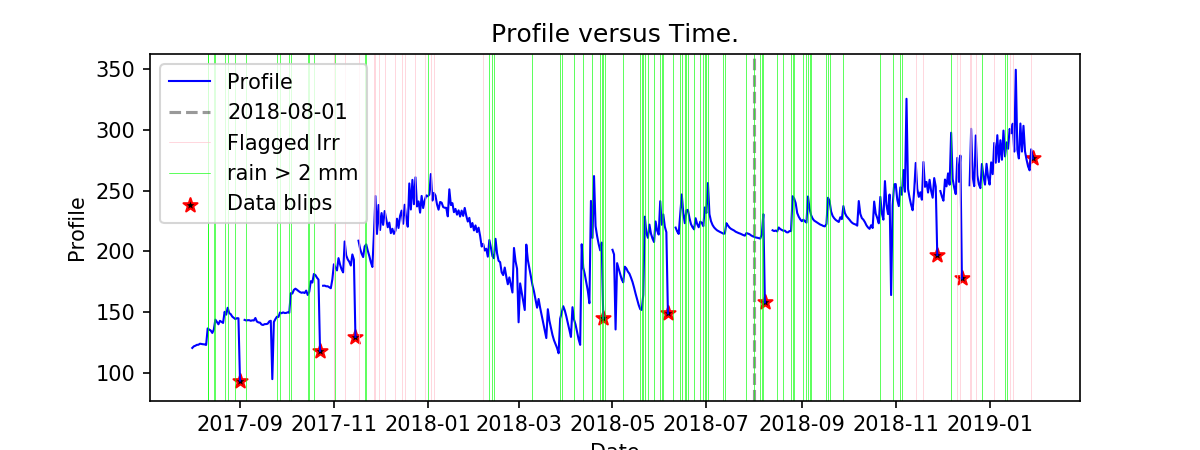

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.set_xlabel('Date')
ax.set_ylabel('Profile')
ax.set_title("Profile versus Time.")
ax.plot(df_profile.index, df_profile["profile"], color="blue", label="Profile", lw="1")
ax.scatter(x=data_blip_days, y=df_profile.loc[data_blip_days, ["profile"]], s=50, color="black", 
            marker="*", label="Data blips", edgecolors="red")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="black", alpha=0.4, linestyle="--", label="2018-08-01")

for d in flag_irrigation_dates:
    ax.axvline(x=d, color="pink", alpha=1.0, linestyle="-", linewidth=0.3)
ax.axvline(x=flag_irrigation_dates[0], color="pink", alpha=1.0, linestyle="-", linewidth=0.3, label="Flagged Irr")

for d in flagged_rain_dates:
    ax.axvline(x=d, color="lime", alpha=1.0, linestyle="-", linewidth=0.3)
ax.axvline(x=flagged_rain_dates[0], color="lime", alpha=1.0, linestyle="-", linewidth=0.3, label="rain > 2 mm")

ax.legend()
plt.show()

Notice that for the dates adjacent to missing data gaps, there is always a strange dip in the `"profile"` value.  These large dips are indicated by the red stars in the above plot.  The data entries associated with these huge dips are also flagged.  What is the reason for these particular readings dipping so low?  These large dips imply that the apple tree had a massive water uptake via absorption through its roots, but physiologically this is not possible.

There are also other profile readings that appear suspicious because of the following pattern: profile(t-1) is some value, say $k$; profile(t) dips very low from profile(t-1); profile(t+1) is close to the value of profile(t-1).  Up next, we try to flag these "large dips" that appear suspicious.

In [37]:
df_profile.loc[data_blip_days ,["difference"]] = np.nan

negative_differences = df_profile[df_profile["difference"] < 0]["difference"].values
percentile_value = np.quantile(negative_differences, q=[0.01, 0.015, 0.02])[2]

large_dip_days = []
for d in df_profile.index:
    try:
        if (df_profile.loc[d, "difference"] < percentile_value) and (df_profile.loc[d + DAY, "difference"] > 0):
            large_dip_days.append(d)
    except KeyError:
        pass

large_dip_days = pd.to_datetime(large_dip_days)
flagger(bad_dates=large_dip_days, brief_desc=LARGE_PROFILE_DIP_DESC, bin_value=1)
reporter(brief_desc=LARGE_PROFILE_DIP_DESC)
print(len(large_dip_days))

0.7% of data is affected due to [Large profile dip].
4


<IPython.core.display.Javascript object>


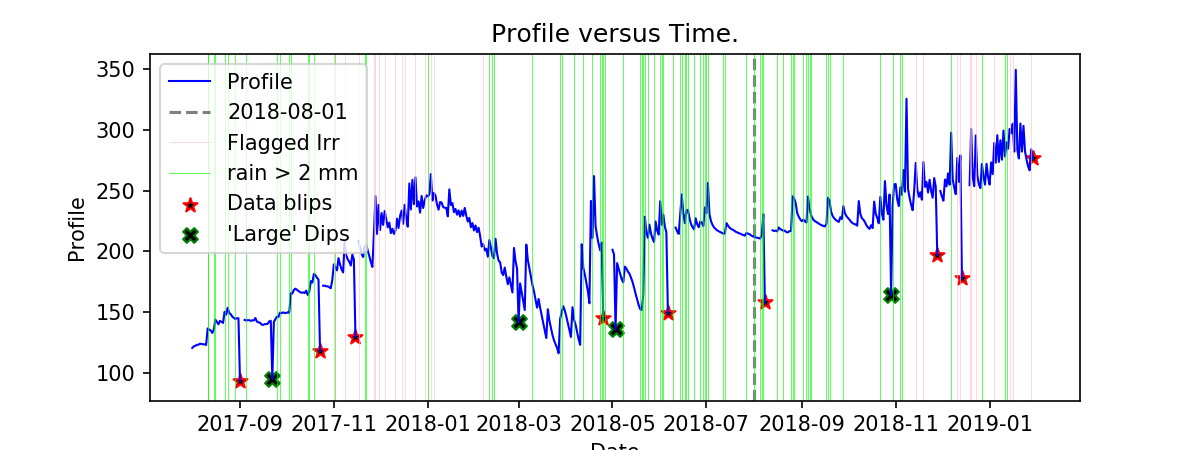

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.set_xlabel('Date')
ax.set_ylabel('Profile')
ax.set_title("Profile versus Time.")
ax.plot(df_profile.index, df_profile["profile"], color="blue", label="Profile", lw=1)
ax.scatter(x=data_blip_days, y=df_profile.loc[data_blip_days, ["profile"]], s=50, color="black", 
            marker="*", label="Data blips", edgecolors="red")
ax.scatter(x=large_dip_days, y=df_profile.loc[large_dip_days, ["profile"]], s=50, color="black", 
            marker="X", label="'Large' Dips", edgecolors="green")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="black", alpha=0.5, linestyle="--", label="2018-08-01")

for d in flag_irrigation_dates:
    ax.axvline(x=d, color="pink", alpha=1.0, linestyle="-", linewidth=0.3)
ax.axvline(x=flag_irrigation_dates[0], color="pink", alpha=1.0, linestyle="-", linewidth=0.3, label="Flagged Irr")

for d in flagged_rain_dates:
    ax.axvline(x=d, color="lime", alpha=1.0, linestyle="-", linewidth=0.3)
ax.axvline(x=flagged_rain_dates[0], color="lime", alpha=1.0, linestyle="-", linewidth=0.3, label="rain > 2 mm")

ax.legend()
plt.show()

# `"heat_units"` versus Time

Notice that heat_units corresponds to column B of the excile spreadsheet.

There are many dates for which the value of `"heat_units"` is jammed and repeats for a long time interval.  This is due to faulty weatherstation data.  Entries for which `"heat_units"` values repeat are flagged, and the actual `"heat_units"` values are replaced with 0.

In [39]:
df_gdd = data.filter(["heat_units"], axis=1)
print(df_gdd.info())
print("-"*30)
print(df_gdd.head())
print("-"*30)
print(df_gdd.describe())
print("-"*30)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 1 columns):
heat_units    550 non-null float64
dtypes: float64(1)
memory usage: 28.6 KB
None
------------------------------
            heat_units
date                  
2017-08-01         0.0
2017-08-02         0.0
2017-08-03         0.0
2017-08-04         0.0
2017-08-05         0.0
------------------------------
       heat_units
count  550.000000
mean     6.127273
std      4.208461
min      0.000000
25%      2.500000
50%      7.400000
75%      8.950000
max     17.650001
------------------------------


In [40]:
df_gdd["hu_diff1"] = df_gdd["heat_units"].diff(periods=1)
df_gdd["hu_diff2"] = df_gdd["heat_units"].diff(periods=2)

In [41]:
condition = (df_gdd["hu_diff1"] == 0.0) | (df_gdd["hu_diff2"] == 0)  # bitwise OR operation
bad_hu_days = df_gdd[condition].index

flagger(bad_dates=bad_hu_days, brief_desc=HU_STUCK_DESC, bin_value=0)
reporter(brief_desc=HU_STUCK_DESC)

53.8% of data is affected due to [Heat Units `stuck`].


In [42]:
df_flag

,binary_value,description
date,,
2017-08-01,0,
2017-08-02,0,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-03,0,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-04,0,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-05,0,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-06,0,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-07,0,Imputed eto. Stuck etc due to stuck eto.
2017-08-08,0,Imputed eto. Stuck etc due to stuck eto.
2017-08-09,0,Imputed eto. Stuck etc due to stuck eto.


In [43]:
df_gdd.loc[bad_hu_days, "heat_units"] = 0.0

In [44]:
def cumulative(s):
    new = s.to_frame()
    new["cumulative"] = 0.0
    for stamp in new.index:
        if (stamp.month == 8) and (stamp.day == 1):
            new.loc[stamp, ["cumulative"]] = 0.0
        elif (stamp.month == 8) and (stamp.day == 2):
            new.loc[stamp, ["cumulative"]] = 0.0 + new.loc[stamp]["heat_units"]
        else:
            new.loc[stamp, ["cumulative"]] = new.loc[(stamp - DAY)]["cumulative"] + new.loc[stamp]["heat_units"]
    return new["cumulative"]


df_gdd["cumul_heat_units"] = cumulative(df_gdd["heat_units"])
# df_gdd.head(n=30)

<IPython.core.display.Javascript object>


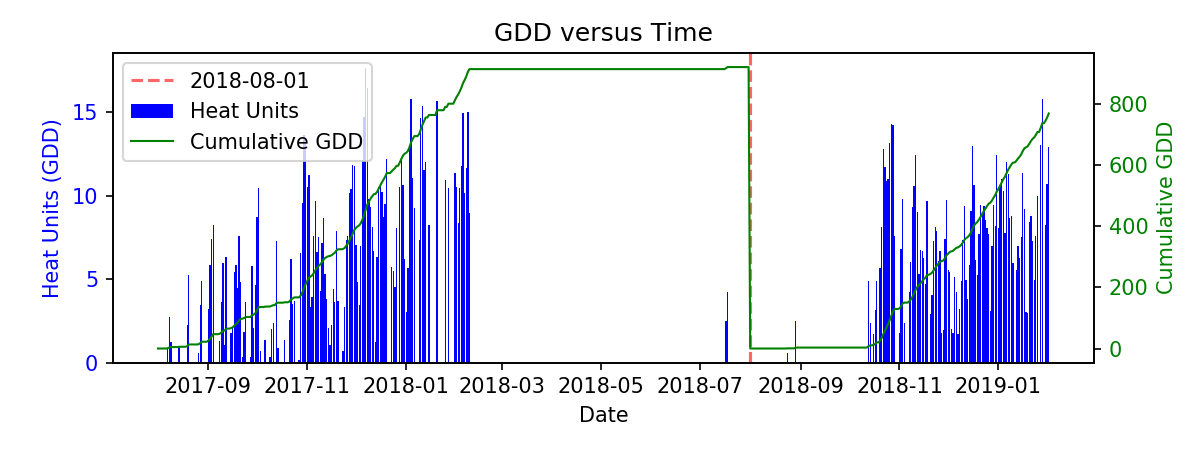

In [45]:
fig = plt.figure()
fig.set_size_inches(8, 3)
ax1 = fig.add_subplot(111)

color = "blue"
ax1.set_title("GDD versus Time")
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Units (GDD)', color=color)
pl1 = ax1.bar(df_gdd.index, df_gdd["heat_units"], color=color, label="Heat Units")
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=datetime.datetime(2018, 8 , 1), color="red", ls="--", alpha=0.6, label="2018-08-01")

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
color="green"
ax2.set_ylabel("Cumulative GDD", color=color)
pl2 = ax2.plot(df_gdd.index, df_gdd["cumul_heat_units"], color=color, label="Cumulative GDD", lw=1)
ax2.tick_params(axis="y", labelcolor=color)

# added these three lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

fig.tight_layout()
plt.show()

As can be seen in the above plot, there are many gaps due to faulty weather station data.  Therefore the green curve representing cumulative growing-degree-days is also affected and not accurate.

# `"etcp"` versus time

Notice that `"etcp"` belongs to column J in the Excel file.  
`"etcp"` is defined as the difference between consecutive `"profile"` readings:

$$
\mathrm{ET}_{cp}(t) = \mathrm{Profile}(t) - \mathrm{Profile}(t-1)
$$

We are mostly interested in the $\mathrm{ET}_{cp}$ entries for which $\mathrm{ET}_{cp} < 0$.  These negative entries reflect incidents in which water was lost from the soil due to: (1) Water Drainage, (2) Luxurious water uptake, (3) Normal water uptake, ((4) and Drought-stress maybe?)

We are not interested in dates in which $\mathrm{ET}_{cp}$ is perturbed by irrigation and/or rain.  For such dates where $\mathrm{ET}_{cp}$ is perturbed, we expect $\mathrm{ET}_{cp} \ge 0$.  Therefore, data entries corresponding to $\mathrm{ET}_{cp} \ge 0$ are flagged.  Furthermore, all $\mathrm{ET}_{cp} \ge 0$ entries are set to `NaN` values (Not a Number).

In [46]:
condition = df_et["etcp"] >= 0.0
bad_etcp_days = df_et[condition].index

flagger(bad_dates=bad_etcp_days, brief_desc=ETCP_POS_DESC, bin_value=1)
reporter(brief_desc=ETCP_POS_DESC)

36.9% of data is affected due to [etcp is positive].


Let us set the $\mathrm{ET}_{cp}$ values for which _all_ the dates in the `df_flag` DataFrame is flagged, due to whatever reason, to `np.nan`.

In [47]:
condition = df_flag["binary_value"] == 1
flagged_dates = df_flag[condition].index

df_et["remaining_etcp"] = df_et["etcp"]
df_et.loc[flagged_dates, "remaining_etcp"] = np.nan
df_et.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2017-08-01 to 2019-02-01
Data columns (total 9 columns):
calendar_week     550 non-null int64
etc               550 non-null float64
et0               550 non-null float64
etcp              550 non-null float64
et0_diff1         549 non-null float64
et0_diff2         548 non-null float64
remaining_et0     545 non-null float64
remaining_etc     254 non-null float64
remaining_etcp    295 non-null float64
dtypes: float64(8), int64(1)
memory usage: 63.0 KB


In [48]:
df_et.describe()

,calendar_week,etc,et0,etcp,et0_diff1,et0_diff2,remaining_et0,remaining_etc,remaining_etcp
count,550.000000,550.000000,550.000000,550.000000,549.000000,548.000000,545.000000,254.000000,295.000000
mean,29.274545,1.637545,5.573127,2.624945,-0.000182,-0.001661,4.604018,1.660118,-6.046203
std,15.800414,1.141910,1.519195,31.245570,1.093288,1.349620,2.034934,1.184330,8.337052
min,1.000000,0.070000,0.710000,-101.230000,-5.380000,-5.260000,0.710000,0.070000,-74.280000
25%,15.250000,0.650000,4.632500,-5.627500,0.000000,0.000000,2.650000,0.480000,-6.940000
50%,33.000000,1.300000,6.510000,-0.940000,0.000000,0.000000,4.430000,1.540000,-4.340000
75%,43.000000,2.890000,6.510000,2.625000,0.090000,0.082500,6.170000,2.847500,-1.260000
max,52.000000,4.000000,8.000000,254.380000,5.260000,5.260000,8.900000,4.000000,-0.050000


At this stage, we are now only left with the etcp < 0 entries (i.e. entries associated with water drainage, luxurious/normal water uptake, and drought-stress).  For simplicity, we multiply these remaining etcp values with -1 so that henceforth we only work with positive values of etcp (which is a little bit more convenient for programming purposes).

In [49]:
df_et["remaining_etcp"] = df_et["remaining_etcp"].multiply(-1)
df_et.describe()

,calendar_week,etc,et0,etcp,et0_diff1,et0_diff2,remaining_et0,remaining_etc,remaining_etcp
count,550.000000,550.000000,550.000000,550.000000,549.000000,548.000000,545.000000,254.000000,295.000000
mean,29.274545,1.637545,5.573127,2.624945,-0.000182,-0.001661,4.604018,1.660118,6.046203
std,15.800414,1.141910,1.519195,31.245570,1.093288,1.349620,2.034934,1.184330,8.337052
min,1.000000,0.070000,0.710000,-101.230000,-5.380000,-5.260000,0.710000,0.070000,0.050000
25%,15.250000,0.650000,4.632500,-5.627500,0.000000,0.000000,2.650000,0.480000,1.260000
50%,33.000000,1.300000,6.510000,-0.940000,0.000000,0.000000,4.430000,1.540000,4.340000
75%,43.000000,2.890000,6.510000,2.625000,0.090000,0.082500,6.170000,2.847500,6.940000
max,52.000000,4.000000,8.000000,254.380000,5.260000,5.260000,8.900000,4.000000,74.280000


<IPython.core.display.Javascript object>


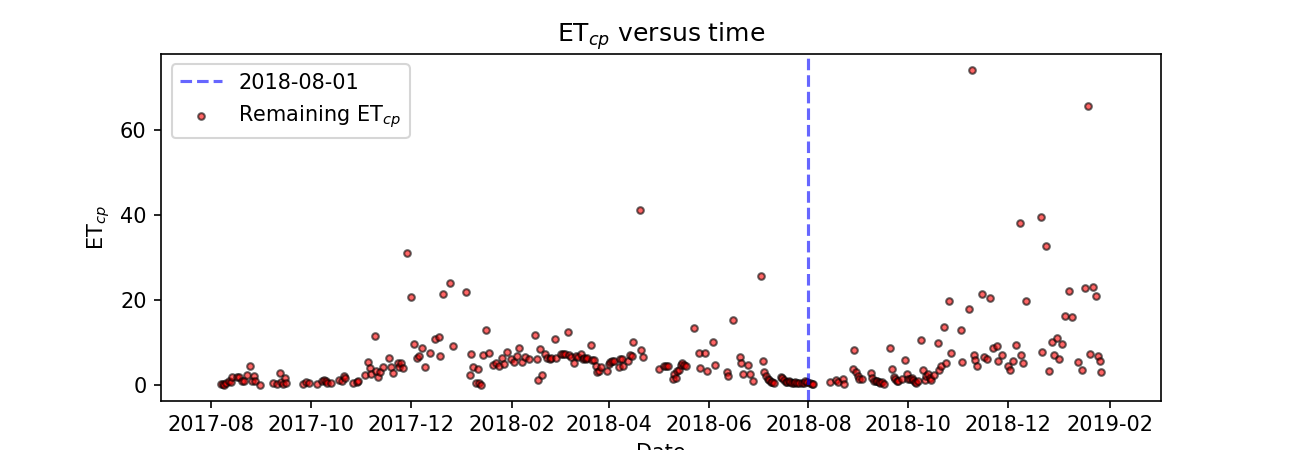

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(8.6, 3)

ax.scatter(df_et.index, df_et["remaining_etcp"], color="red", label="Remaining $\mathrm{ET}_{cp}$", 
        marker="o", s=10, edgecolors="black", linewidth=1, alpha=0.6)
ax.set_xlabel("Date")
ax.set_ylabel("$\mathrm{ET}_{cp}$")
ax.set_title("$\mathrm{ET}_{cp}$ versus time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", alpha=0.6, ls="--", label="2018-08-01")
ax.legend()
plt.show()

# Remove $\mathrm{ET}_{cp}$ outliers

As can be seen in the figure above, there are some outliers still present in the remaining $\mathrm{ET}_{cp}$ dataset.

These outliers are most likely associated with phases of water-drainage and luxurious water uptake.  We, on the other hand, are only interested in phases corresponding to normal water uptake.

In [51]:
s = df_et["etcp"].quantile([0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90, 0.91, 0.92, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
s

0.50     -0.9400
0.60     -0.4360
0.70      0.3750
0.75      2.6250
0.80      5.7960
0.85     11.5200
0.90     18.4620
0.91     21.5731
0.92     22.2936
0.94     27.0764
0.95     30.5165
0.96     36.8836
0.97     52.4923
0.98     76.7150
0.99    186.6960
1.00    254.3800
Name: etcp, dtype: float64

From an educated guess, let us accept a maximum eto of 12.0 mm.  Let us make another educated guess and allow for a maximum $k_{cp}$ value of 0.8 (of course, these educated guesses vary from cultivar to cultivar).  This implies that the maximum allowed value for etcp is as follows:

$$
\mathrm{max}(\mathrm{ET}_{cp}) = 0.8 \times 12 = 9.6 \approx 10\,\mathrm{mm}
$$

Consequently, we flag all $\mathrm{ET}_{cp} > 10\, \mathrm{mm}$ data entries.

Let us perform a filtering process to get rid of all $\mathrm{ET}_{cp}$ values higher than 10:

In [52]:
condition = df_et["remaining_etcp"] >= ETCP_MAX
bad_high_etcp_dates = df_et[condition].index

df_et.loc[bad_high_etcp_dates, ["remaining_etcp"]] = np.nan

flagger(bad_dates=bad_high_etcp_dates, brief_desc=ETCP_OUTLIERS_DESC, bin_value=1)
reporter(brief_desc=ETCP_OUTLIERS_DESC)

7.6% of data is affected due to [etcp outliers].


# Remove dates for which luxurious water uptake is present

But remember, we only tolerate etcp values for which $k_{cp} \le 0.8$.  Therefore, to ensure that all luxurious water-uptake phases are completely flagged, we perform another flagging operation that flags data entries for which $\mathrm{ET}_{cp} > 0.8\times\mathrm{ET}_0$ (for extra insurance).

In [53]:
condition = df_et["remaining_etcp"] > df_et["remaining_et0"].mul(KCP_MAX, fill_value=np.nan)
luxurious_dates = df_et[condition].index

df_et.loc[luxurious_dates, ["remaining_etcp"]] = np.nan

flagger(bad_dates=luxurious_dates, brief_desc=LUX_DESC, bin_value=1)
reporter(brief_desc=LUX_DESC, remaining=True)

20.9% of data is affected due to [Luxurious water uptake].
After all the flagging that has taken place in this entire notebook, only 25% of your data is useful.


# Evaluate the remaining $\mathrm{ET}_{cp}$ entries which are _hopefully_ valid data points

In [54]:
condition = df_et["remaining_etcp"].notnull()
useful_dates = df_et[condition].index

<IPython.core.display.Javascript object>


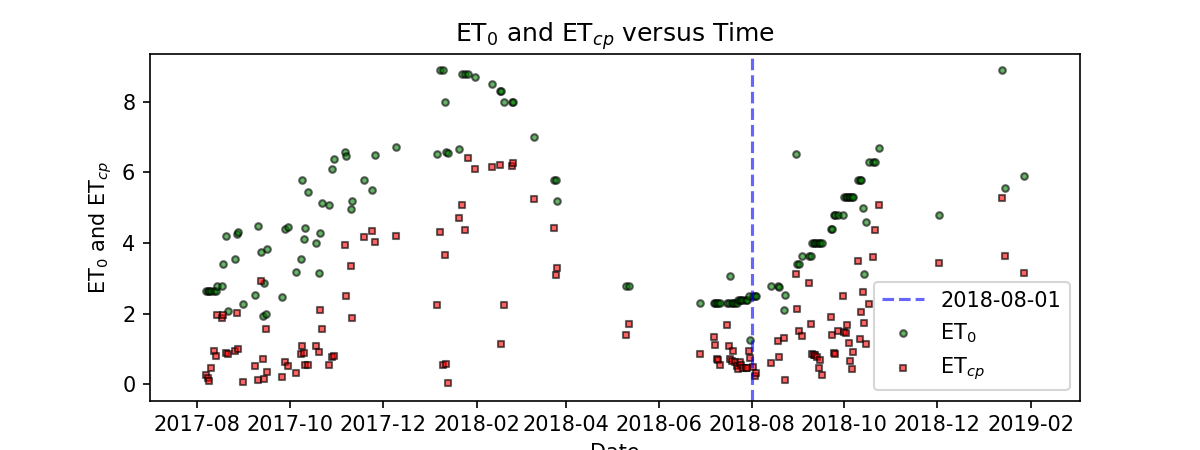

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.scatter(useful_dates, df_et.loc[useful_dates, ["remaining_et0"]], color="green", label="$\mathrm{ET}_0$", 
        marker="o", s=10, edgecolors="black", linewidth=1, alpha=0.6)
ax.scatter(useful_dates, df_et.loc[useful_dates, ["remaining_etcp"]], color="red", label="$\mathrm{ET}_{cp}$", 
        marker="s", s=10, edgecolors="black", linewidth=1, alpha=0.6)
ax.set_xlabel("Date")
ax.set_ylabel("$\mathrm{ET}_0$ and $\mathrm{ET}_{cp}$")
ax.set_title("$\mathrm{ET}_0$ and $\mathrm{ET}_{cp}$ versus Time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", alpha=0.6, ls="--", label="2018-08-01")
ax.legend()
plt.show()

# How must we flag events of drought-stress?

One line of reasoning is that during phases of drough-stress we expect very small changes in the waterbalance "Profile" readings.  According to this logic, we expect for drought-stress that:

$$
\mathrm{Profile}(t) - \mathrm{Profile}(t-1) = \mathrm{ET}_{cp}(t) < \varepsilon
$$

where $\varepsilon$ is a relatively small value, such as, for example, $\varepsilon = 0.1$.

It was suggested we evaluate kcp and compare it to the accepted norm (on file).  If kcp differs by more than 50% +- then flagging should take place.

# Rough calculation of $k_{cp}$

Basically, after all the necessary flagging has been carried out, we can proceed to calculate $k_{cp}$ as follows:

$$
k_{cp} = \frac{\mathrm{ET}_{cp}}{\mathrm{ET}_0}
$$

In the plot below, we show the calculated $k_{cp}$ for entries containing both valid $\mathrm{ET}_{cp}$ and $\mathrm{ET}_0$ entries.

<IPython.core.display.Javascript object>


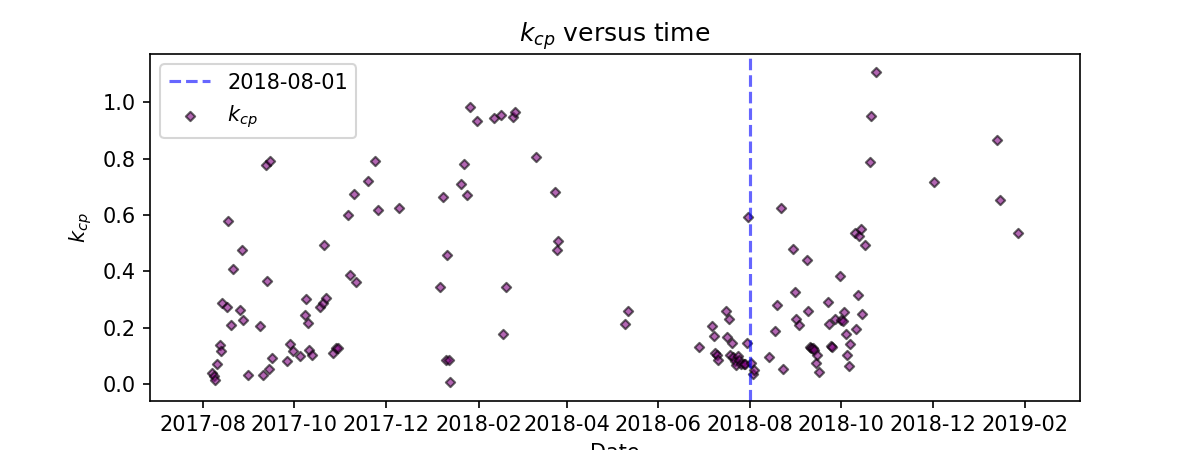

In [56]:
df_et["kcp"] = df_et["remaining_etcp"].div(df_et["et0"], fill_value=np.nan)

fig, ax = plt.subplots()
fig.set_size_inches(8, 3)

ax.scatter(df_et.index, df_et["kcp"], color="purple", label="$k_{cp}$",
        marker="D", s=10, edgecolors="black", linewidth=1, alpha=0.6)
ax.set_xlabel("Date")
ax.set_ylabel("$k_{cp}$")
ax.set_title("$k_{cp}$ versus time")
ax.axvline(x=datetime.datetime(2018, 8, 1), color="blue", alpha=0.6, ls="--", label="2018-08-01")
ax.legend()
plt.show()

# Merge the original `data` DataFrame with the `df_flag` DataFrame

In [57]:
master_data = pd.concat([data, df_flag], axis=1, join="inner")
master_data.head(n = 100)

,heat_units,rain,erain,total_irrig,tot_eff_irrig,etc,ety,et0,etcp,rzm_source,profile,original_unit_system,calendar_week,binary_value,description
date,,,,,,,,,,,,,,,
2017-08-01,0.000000,0.0,0.0,0.0,0.00,0.82,0.68,6.80,120.37,Electronic Probe,120.37,si,31,1,etcp is positive.
2017-08-02,0.000000,1.0,0.0,0.0,0.00,0.49,0.68,6.80,1.32,Electronic Probe,121.69,si,31,1,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-03,0.000000,0.2,0.0,0.0,0.00,0.49,0.68,6.80,0.50,Electronic Probe,122.19,si,31,1,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-04,0.000000,0.0,0.0,0.0,0.00,0.49,0.68,6.80,0.71,Electronic Probe,122.91,si,31,1,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-05,0.000000,0.0,0.0,0.0,0.00,0.49,0.68,6.80,0.10,Electronic Probe,123.01,si,31,1,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-06,0.000000,0.0,0.0,0.0,0.00,0.49,0.68,6.80,0.86,Electronic Probe,123.87,si,31,1,Imputed eto. Stuck etc due to stuck eto. Heat ...
2017-08-07,0.800000,0.0,0.0,0.0,0.00,0.74,0.68,6.80,-0.28,Electronic Probe,123.59,si,32,0,Imputed eto. Stuck etc due to stuck eto.
2017-08-08,2.750000,0.0,0.0,0.0,0.00,0.74,0.68,6.80,-0.19,Electronic Probe,123.40,si,32,0,Imputed eto. Stuck etc due to stuck eto.
2017-08-09,1.250000,0.0,0.0,0.0,0.00,0.49,0.19,6.80,-0.10,Electronic Probe,123.30,si,32,0,Imputed eto. Stuck etc due to stuck eto.


In [58]:
master_data.count()

heat_units              550
rain                    550
erain                   550
total_irrig             550
tot_eff_irrig           550
etc                     550
ety                     550
et0                     550
etcp                    550
rzm_source              550
profile                 550
original_unit_system    550
calendar_week           550
binary_value            550
description             550
dtype: int64